# New York City Taxi Trip Duration Estimate 
-  Regression project 

### Kaggle result (RMSE)
- **0.46931 (private)** / 0.47176(public)  - 737 (58%)

In [1]:
%matplotlib inline
from taxi_pakage import *
taxi = pd.read_csv("edited_taxi.csv")
taxi['sqrt_log_dist'] = taxi['dist'].apply(lambda x: np.sqrt(np.log1p(x)))
taxi['log_duration'] = taxi['trip_duration'].apply(lambda x: np.log1p(x))
taxi['velo'] = taxi['dist']/taxi['trip_duration']*3600 # km/h

In [2]:
def zone(x):
    if x< 0.1: return '0.1'
    elif x < 0.5: return '0.5'
    elif x < 1.0: return '1.0'
    elif x < 1.5: return '1.5'
    elif x < 1.9: return '1.9'
    else: return 'over'

taxi['zone'] = taxi['sqrt_log_dist'].apply(zone)
taxi['no_passenger'] = taxi['passenger_count'].apply(lambda x: 1 if x==0 else 0)

## Model
아웃라이어 제거-by fox 

In [3]:
model = sm.OLS.from_formula("log_duration ~ \
                             + C(zone)/scale(sqrt_log_dist)\
                             + C(holiday)\
                             + C(weather_event)\
                             + C(hour):C(weekday)\
                             + C(no_passenger)\
                             + scale(sqrt_log_dist)*C(vendor_id)\
                             + scale(month) \
                             + scale(dropoff_latitude)+ scale(dropoff_longitude) \
                             + 0", data = taxi.loc[:100000])
result = model.fit()

In [4]:
taxi_filtered, dropped = erase_outlier_np(result, taxi, category=True, dropped=True)

model = sm.OLS.from_formula("log_duration ~ \
                             + C(zone)/scale(sqrt_log_dist)\
                             + C(holiday)\
                             + C(weather_event)\
                             + C(hour):C(weekday)\
                             + C(no_passenger)\
                             + scale(sqrt_log_dist)*C(vendor_id)\
                             + scale(month) \
                             + scale(dropoff_latitude)+ scale(dropoff_longitude) \
                             + 0", data = taxi_filtered.loc[400000:600000])
result1 = model.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     2085.
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        23:10:41   Log-Likelihood:            -1.2974e+05
No. Observations:              200001   AIC:                         2.599e+05
Df Residuals:                  199814   BIC:                         2.618e+05
Df Model:                         186                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
C(zone)[0.1]                             -23.5497      0.521    -45.237      0.000     -24.570     -22.529
C(zone)[0.5]                               6.2186      0.072     86.284      0.000       6.077       6.360
C(zone)[1.0]                               6.1741      0.019    319.731      0.000       6.136       6.212
C(zone)[1.5]                               6.1685      0.019    325.041      0.000       6.131       6.206
C(zone)[1.9]                               6.2470      0.028    221.581      0.000       6.192       6.302
C(zone)[over]                             13.7885      0.760     18.146      0.000      12.299      15.278
C(holiday)[T.1]                           -0.0929      0.007    -13.402      0.000      -0.107      -0.079
C(weather_event)[T.1]                     -0.0138      0.004     -3.638      0.000      -0.021      -0.006
C(no_passenger)[T.1]                      -2.1051      0.207    -10.145      0.000      -2.512      -1.698
C(vendor_id)[T.2]                          0.0209      0.002     10.067      0.000       0.017       0.025
C(weekday)[T.1]                            0.0218      0.026      0.829      0.407      -0.030       0.073
C(weekday)[T.2]                            0.0643      0.026      2.519      0.012       0.014       0.114
C(weekday)[T.3]                            0.0711      0.025      2.899      0.004       0.023       0.119
C(weekday)[T.4]                            0.1808      0.023      7.810      0.000       0.135       0.226
C(weekday)[T.5]                            0.2379      0.022     10.694      0.000       0.194       0.282
C(weekday)[T.6]                            0.2223      0.022     10.133      0.000       0.179       0.265
C(hour)[T.1]:C(weekday)[0]                -0.0230      0.031     -0.736      0.462      -0.084       0.038
C(hour)[T.2]:C(weekday)[0]                -0.0153      0.037     -0.420      0.674      -0.087       0.056
C(hour)[T.3]:C(weekday)[0]                 0.0204      0.041      0.502      0.616      -0.059       0.100
C(hour)[T.4]:C(weekday)[0]                -0.0606      0.041     -1.494      0.135      -0.140       0.019
C(hour)[T.5]:C(weekday)[0]                -0.0723      0.034     -2.112      0.035      -0.139      -0.005
C(hour)[T.6]:C(weekday)[0]                -0.0303      0.025     -1.195      0.232      -0.080       0.019
C(hour)[T.7]:C(weekday)[0]                 0.2162      0.023      9.383      0.000       0.171       0.261
C(hour)[T.8]:C(weekday)[0]                 0.4016      0.022     17.883      0.000       0.358       0.446
C(hour)[T.9]:C(weekday)[0]                 0.4731      0.023     20.996      0.000       0.429       0.517
C(hour)[T.10]:C(weekday)[0]                0.4917      0.023     21.237      0.000     

---

### Cross Validation

In [5]:
score, result_set = cross_validater("log_duration ~ \
                             + C(zone)/scale(sqrt_log_dist)\
                             + C(holiday)\
                             + C(weather_event)\
                             + C(weekday):C(hour)\
                             + C(no_passenger)\
                             + scale(sqrt_log_dist)*C(vendor_id)\
                             + scale(month) \
                             + scale(dropoff_latitude)+ scale(dropoff_longitude) \
                             + 0", taxi_filtered[1100000:], 3, r_seed=2, target_log=True)

In [6]:
score

[0.48676554019526785, 0.46101854292973454, 0.4658230001333184]

In [7]:
result_set

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.661,270074.019,271990.239,1284.656,0.0,0.0,0.0,1.996,log_duration ~ + ...
1,0.655,275477.967,277394.188,1271.454,0.0,0.0,0.0,2.002,log_duration ~ + ...
2,0.658,273324.976,275241.197,2299.031,0.0,0.0,0.0,1.994,log_duration ~ + ...


---

In [8]:
test = pd.read_csv("edited_test.csv")
test['sqrt_log_dist'] = test['dist'].apply(lambda x: np.sqrt(np.log1p(x)))
test['zone'] = test['sqrt_log_dist'].apply(zone)
test['no_passenger'] = test['passenger_count'].apply(lambda x: 1 if x==0 else 0)

In [9]:
# 테스트 데이터를 통해 y값 예측
y_hat = result1.predict(test)

In [10]:
y_hat = y_hat.apply(lambda x: (round(np.exp(x))))
ans = pd.concat([test['id'], y_hat], axis=1)
ans.rename(columns={'id':'id' , 0:'trip_duration'}, inplace=True)
ans[ans['trip_duration']>50000] 

,id,trip_duration
324125,id0505885,8.909081e+14


In [11]:
len(ans[pd.isna(ans['trip_duration'])])

0

In [12]:
# ans['trip_duration']=(ans['trip_duration']).fillna(950)

In [13]:
test.loc[324125] 

id                              id0505885
vendor_id                               2
pickup_datetime       2016-03-29 14:28:46
passenger_count                         2
pickup_longitude                 -121.933
pickup_latitude                   37.3896
dropoff_longitude                -121.933
dropoff_latitude                  37.3894
store_and_fwd_flag                      0
dist                            0.0295004
month                                   3
day                                    29
hour                                   14
weekday                                 1
holiday                                 0
work                                    1
dhour                                   3
weather_event                           1
sqrt_log_dist                     0.17051
zone                                  0.5
no_passenger                            0
Name: 324125, dtype: object

In [14]:
# ans['trip_duration'].loc[324125] =950 # 너무 큰 숫자는 int변환이 불가능
ans['trip_duration'] = ans['trip_duration'].apply(lambda x: int(x))
# Kaggle 제출파일
ans.to_csv('basic_model.csv', index=False)

---

## 검정

이 모델의 잔차는 정규성을 띄지 않는다.

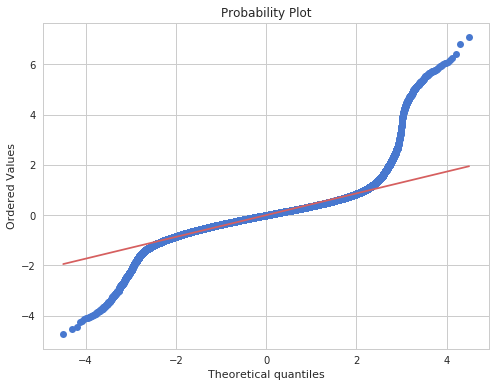

In [15]:
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result1.resid, plot = plt)
plt.show()

## direct distance
coef : -6.7921

#### 직선 거리가 증가할 수록 이동시간이 짧아진다.

why? 
- 짧은 거리 이동 -> 도심내 이동 -> 차막힘
- 먼 거리 이동 -> 외곽으로 이동 -> 고속도로 등 이용 가능

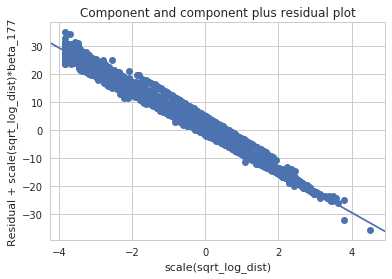

In [16]:
sm.graphics.plot_ccpr(result1, "scale(sqrt_log_dist)")
plt.show()

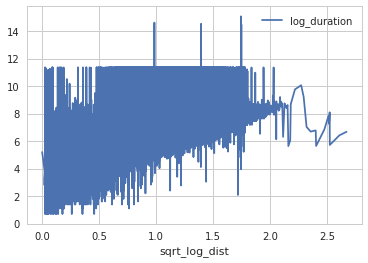

In [17]:
taxi_filtered.pivot_table("log_duration","sqrt_log_dist", aggfunc='mean').plot()

## zone
이동거리로 구간을 나눔 (초단거리, 단거리, 중거리, 중장거리, 장거리, 이상치)

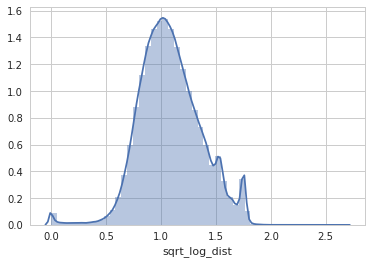

In [18]:
sns.distplot(taxi_filtered["sqrt_log_dist"])
plt.show()

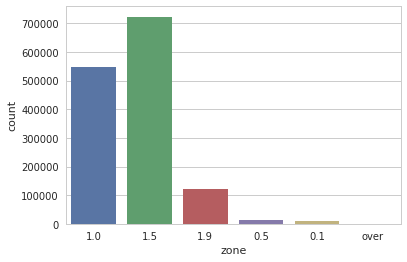

In [19]:
sns.countplot(taxi_filtered['zone'])
plt.show()

**1km이하**로 운행한 택시는 **이동 시간이 짧을** 확률이 높다.

In [20]:
np.exp(np.square(0.1))

1.010050167084168

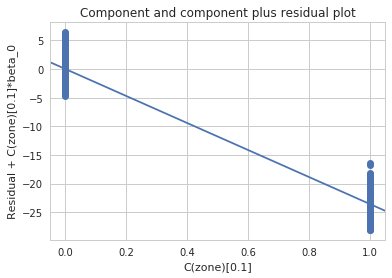

In [21]:
sm.graphics.plot_ccpr(result1, "C(zone)[0.1]") # coef -21.4187
plt.show()

**36km이상** 운행한 택시는 **이동 시간이 길** 확률이 높다.

In [22]:
np.exp(np.square(1.9))

36.966052814822504

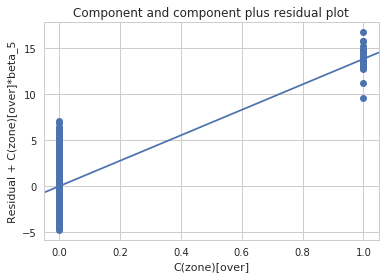

In [23]:
sm.graphics.plot_ccpr(result1, "C(zone)[over]") # coef 12.7330
plt.show()

## zone:dist
zone에 따라 거리 비례 이동시간이 달라진다. (기울기 변화)

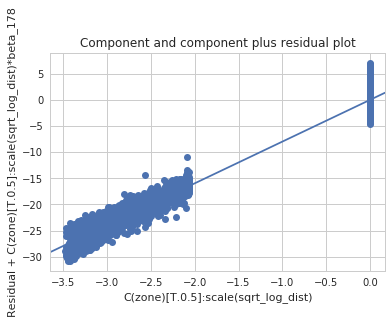

In [24]:
sm.graphics.plot_ccpr(result1, "C(zone)[T.0.5]:scale(sqrt_log_dist)") # 단거리 : coef 7.3973
plt.show()

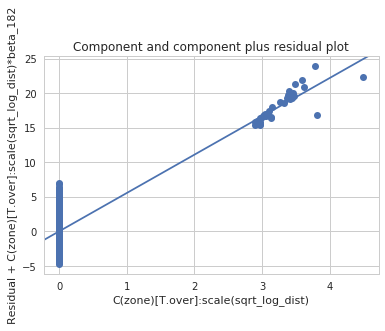

In [25]:
sm.graphics.plot_ccpr(result1, "C(zone)[T.over]:scale(sqrt_log_dist)") # 장거리 : coef 5.2826
plt.show()

## weekday:hour
- 날짜와 시간 조합에 따라 duration이 달라진다.

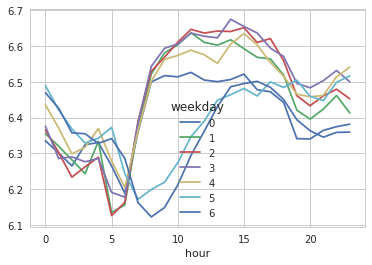

In [26]:
taxi_filtered.pivot_table("log_duration","hour","weekday", aggfunc='mean').plot()

#### 월요일 오전 7시
- duration이 길어진다 - 출근길이라 속도가 안나옴
- coef : 0.2233

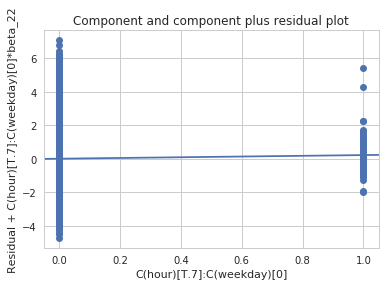

In [27]:
sm.graphics.plot_ccpr(result1, "C(hour)[T.7]:C(weekday)[0]")
plt.show()

#### 토요일 오전 6시
- duration이 짧다 - 휴일 아침이라 빠르게 도착
- coef : -0.3800

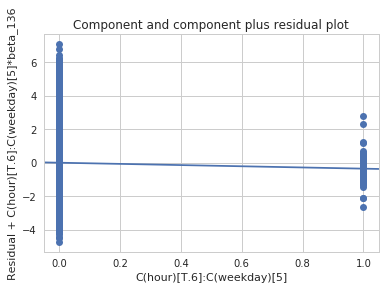

In [28]:
sm.graphics.plot_ccpr(result1, "C(hour)[T.6]:C(weekday)[5]")
plt.show()

### C(weather_event)[T.1]	

- 날씨가 매우 좋지 않았던 날의 경우, duration이 짧아진다 - 장거리 외출 자제
- coef : -0.0087

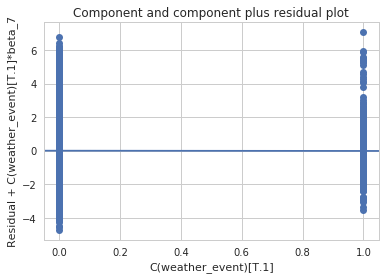

In [29]:
sm.graphics.plot_ccpr(result1, "C(weather_event)[T.1]") 
plt.show()

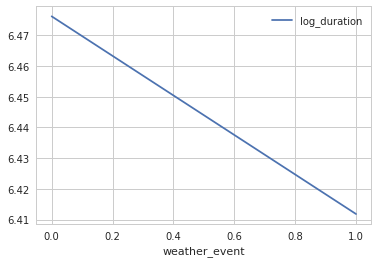

In [30]:
taxi_filtered.pivot_table("log_duration", "weather_event", aggfunc='mean').plot()
plt.show()

## holiday 

휴일의 평균 duration이 짧다
- coef : -0.0969

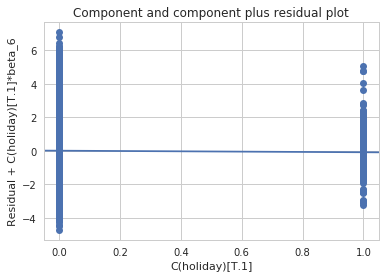

In [31]:
sm.graphics.plot_ccpr(result1, "C(holiday)[T.1]")
plt.show()

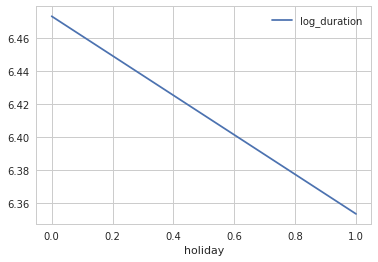

In [32]:
taxi_filtered.pivot_table("log_duration", "holiday", aggfunc='mean').plot()
plt.show()

## month 

날이 풀릴 수록 이동 시간이 증가한다 
- 외출 증가
- coef : 0.0251

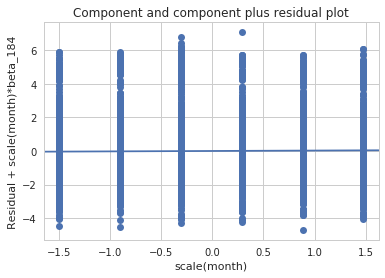

In [33]:
sm.graphics.plot_ccpr(result1, "scale(month)")
plt.show()

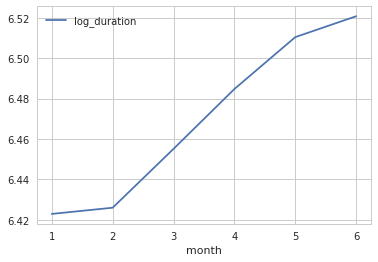

In [34]:
taxi_filtered.pivot_table("log_duration", "month", aggfunc='mean').plot()
plt.show()

## vendor_id

2번 밴더를 이용하는 택시의 평균 이동시간이 길다
- coef 0.0226

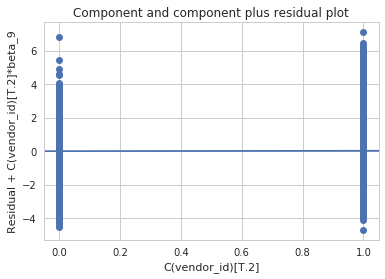

In [35]:
sm.graphics.plot_ccpr(result1, "C(vendor_id)[T.2]")
plt.show()

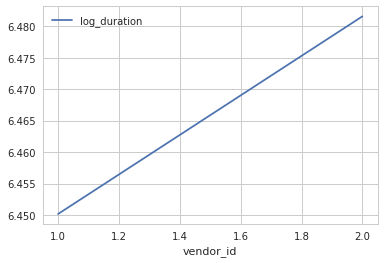

In [36]:
taxi.pivot_table("log_duration","vendor_id", aggfunc='mean').plot()

###  scale(sqrt_log_dist) : vendor_id

vendor 2 경우에도 거리가 길어지면 이동 시간이 줄어들지만 기울기가 많이 작아진다.
- coef : -0.0356 
- coef of scale(sqrt_log_dist)  : -6.7921

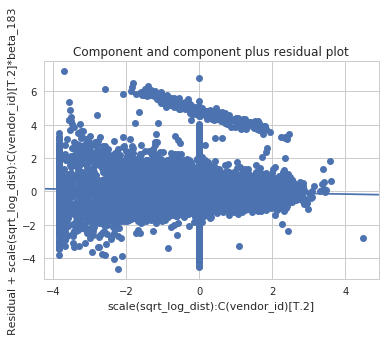

In [37]:
sm.graphics.plot_ccpr(result1, "scale(sqrt_log_dist):C(vendor_id)[T.2]") 
plt.show()

## no_passenger

승객이 없는 경우 duration이 짧아진다.
- coef : -1.5421

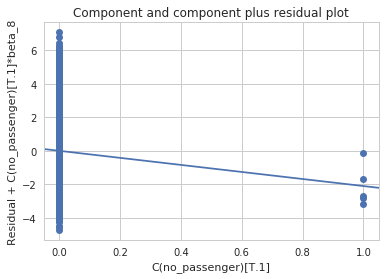

In [38]:
sm.graphics.plot_ccpr(result1, "C(no_passenger)[T.1]")
plt.show()

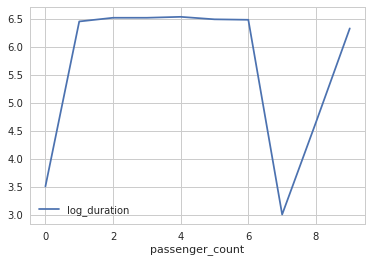

In [39]:
taxi_filtered.pivot_table("log_duration","passenger_count", aggfunc='mean').plot()

## dropoff_latitude

내린 장소의 latitude가 증가할수록 duration이 짧아진다.
- coef : -0.0439

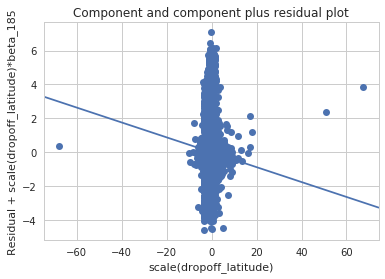

In [40]:
sm.graphics.plot_ccpr(result1, "scale(dropoff_latitude)")
plt.show()

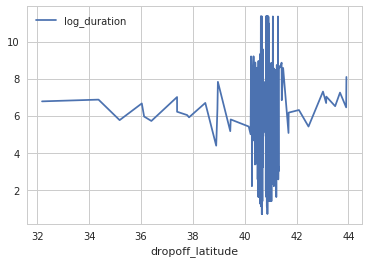

In [41]:
taxi_filtered.pivot_table("log_duration","dropoff_latitude", aggfunc='mean').plot()
plt.show()

## dropoff_longitude

내린 장소의 longitude가 증가할수록 duration이 짧아진다.
- coef : -0.0231

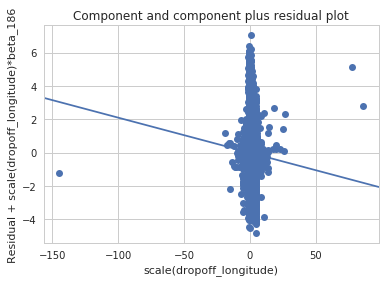

In [42]:
sm.graphics.plot_ccpr(result1, "scale(dropoff_longitude)")
plt.show()

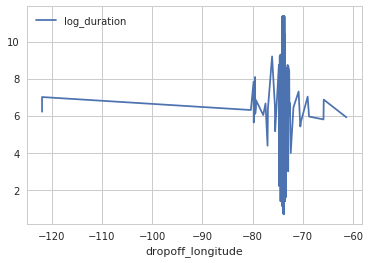

In [43]:
taxi_filtered.pivot_table("log_duration","dropoff_longitude", aggfunc='mean').plot()
plt.show()